# Building a Predictor

Now that our data is in here and working the next step is to build the MODEL so we can put it to practice

In [1]:
# Importing PyTorch libraries and the traintest split function
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

# Importing libraries for plotting, data, and math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Importing Data and Splitting

First step of any machine learning model is to import the data you want to work with and split it into our training and testing data. We will be using the train_test_split function from sklearn to do this.

In [2]:
# Importing our data
data = pd.read_csv('ufc_fights.csv')
data.head()

,HeightDiff,WeightDiff,ReachDiff,WinDiff,ExpDiff,Winner
0,-2.0,-7.0,0.0,-0.062500,16,1
1,-2.0,-16.0,-1.0,-0.205357,40,1
2,-2.0,-26.0,0.0,-0.221591,6,1
3,-2.0,4.0,0.0,0.029605,3,1
4,-2.0,-13.0,1.0,-0.145833,-4,1


In [3]:
# Defining the features and the target
X = data[['HeightDiff', 'WeightDiff', 'ReachDiff', 'WinDiff', 'ExpDiff']]
y = data['Winner']
y = torch.eye(2)[y]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=128)
X_train.head()

,HeightDiff,WeightDiff,ReachDiff,WinDiff,ExpDiff
3250,0.0,0.0,1.0,0.136364,0
1261,-1.0,0.0,-2.0,0.123377,-6
22,-2.0,-1.0,1.0,0.184783,9
619,0.0,0.0,-4.0,0.103831,1
114,1.0,0.0,1.0,0.070175,-2


In [4]:
y_train

tensor([[0., 1.],
        [0., 1.],
        [1., 0.],
        ...,
        [1., 0.],
        [0., 1.],
        [0., 1.]])

# Making PyTorch understand our data

Because PyTorch is a library that can use Tensors we are going to convert all of our data into tensors to speed up the process of training our model and also so we dont have to do it later.

In [5]:
# Assuming you have already defined X_train_tensor, X_test_tensor, y_train, and y_test

# Convert training data into float tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)

# Convert target labels into long tensors (integers)
y_train_tensor = y_train.clone().detach().to(torch.float32)
y_test_tensor = y_test.clone().detach().to(torch.float32)

# Define the train and test datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create the train and test data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Making the Neural Network Architecture

Given that our data is not very complex we will be using a simple neural network with 2 hidden layers and 1 output layer. We will be using the ReLU activation function for our hidden layers and the Sigmoid activation function for our output layer.

In [6]:
class Net(nn.Module):
    """
    Defining the neural network architecture with 2 hidden layers and 3 fully connected layers
    
    forward: like all neural networks, this function takes in the input and passes it through the layers
    
    loss
    """
    def __init__(self, input_size=5, hidden_1=5, output_size=2):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_1)
        self.fc2 = nn.Linear(hidden_1, output_size)
        self.sigmoid = nn.Sigmoid() 
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        output = self.sigmoid(x)
        return output
    
    def loss(self, y_pred, y_true):
        # Binary cross entropy loss function
        criterion = nn.BCEWithLogitsLoss()
        return criterion(y_pred, y_true)
    
    
# setting this variable for the future
net = Net()

# Optimizer Function and Setting Device

Setting the device so it will use the GPU is there is one, and also using the Adam optimizer due to our smaller dataset, and speed.

In [7]:
def optimizer(lr = 0.01):
    
    # Adam optimizer
    optimizer = optim.Adam(net.parameters(), lr=lr)
    return optimizer

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

optimizer_ = optimizer()

# Training Loop

Now that we have most of our functions made we can now make our training loop. This is where we will be training our model and seeing how well it does.

In [8]:
def training(numb_epochs=10):
    # Saving all epoch losses to visualize later
    epoch_losses = []
    
    # Training the model for how many times we say to
    for epoch in range(numb_epochs):
        # Saving the running loss
        running_loss = 0.0
        
        for inputs, labels in train_loader:
            # Moving the data to the GPU (unless I am on my laptop)
            inputs, labels = inputs.to(device), labels.to(device)
            # zero the gradients
            optimizer_.zero_grad()
            # Forward pass
            outputs = net(inputs)
            # Squeeze outputs to match the shape of labels
            outputs = outputs
            # Calculating the loss  
            loss = net.loss(outputs, labels)
            # Backward pass to compute the gradients
            loss.backward()
            # Updating Parameters
            optimizer_.step()
            # Update Running loss for this epoch
            running_loss += loss.item()
        
        # Calculate the average loss for this epoch
        epoch_loss = running_loss / len(train_loader)
        epoch_losses.append(epoch_loss)
        
        # Print the average loss for this epoch
        print(f"Epoch {epoch + 1}, Loss: {epoch_loss}")
    
    # Plotting loss values
    plt.plot(range(1, numb_epochs + 1), epoch_losses, marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss vs. Epochs')
    plt.grid(True)
    plt.show()
    
    # DONE
    print("Training finished.")


# Starting the Training

Epoch 1, Loss: 0.7019973439555014
Epoch 2, Loss: 0.691411204107346
Epoch 3, Loss: 0.6870200041801698
Epoch 4, Loss: 0.6728023705943939
Epoch 5, Loss: 0.6615581616278617
Epoch 6, Loss: 0.6588094157557334
Epoch 7, Loss: 0.656672542710458
Epoch 8, Loss: 0.6582630592007791
Epoch 9, Loss: 0.6575275209642226
Epoch 10, Loss: 0.6565334393132117
Epoch 11, Loss: 0.6557058826569588
Epoch 12, Loss: 0.6562187117914999
Epoch 13, Loss: 0.6565799155542927
Epoch 14, Loss: 0.6571357354041069
Epoch 15, Loss: 0.6563896940600488
Epoch 16, Loss: 0.6558985721680426
Epoch 17, Loss: 0.6554783790342269
Epoch 18, Loss: 0.6562784129573452
Epoch 19, Loss: 0.6574997751943527
Epoch 20, Loss: 0.6562606192404224
Epoch 21, Loss: 0.6557550372615937
Epoch 22, Loss: 0.6558383772450108
Epoch 23, Loss: 0.6550231364465529
Epoch 24, Loss: 0.6561995929287326
Epoch 25, Loss: 0.6557274018564532
Epoch 26, Loss: 0.6552553515280447
Epoch 27, Loss: 0.656061403982101
Epoch 28, Loss: 0.65491607727543
Epoch 29, Loss: 0.6543098053624553

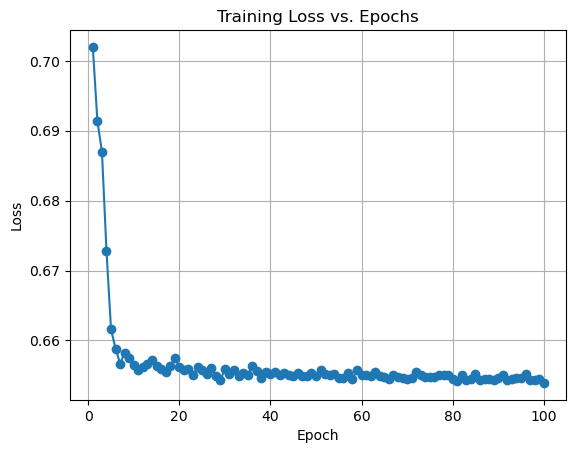

Training finished.


In [9]:
numb_epochs = 100
training(numb_epochs)

# Evaluate the Model

We got the model to train wooooooooo now we have to see if it is actually any good

In [10]:
def evaluate_model(model, test_loader, criterion):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, torch.argmax(labels, dim=1))
            total_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == torch.argmax(labels, dim=1)).sum().item() 

    test_loss = total_loss / len(test_loader)
    test_accuracy = 100 * correct / total

    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# PLEASE READ

**The test accuracy looks very low, however we must also realize that this is not as simple as training dogs and cat images and the MNIST dataset thing**

**UFC fights have upsets and injuries, and sadly rigging so we ARE NOT EXPECTING really high performance like 90% in this model it is just UNREALISTIC**

In [11]:
criterion = nn.CrossEntropyLoss()
evaluate_model(net, test_loader, criterion)

Test Loss: 0.6308, Test Accuracy: 66.02%
